# **Location Scouting for new Lottery POS Locations**
by Hugo Bertini @ 2020.06   
###### _*POS: Point Of Sales_

## **Introduction**

**The Goal**   

Find the adequate locations for a new Lottery POS.   
This is one way of assisting the Commercial Network Managers in the decision of selecting a new location or of assessing whether a proposal for a new POS is suitable. 

**Background**   

The Lottery business strongly relies on the proximity with their audience. And this proximity happens at many different levels and manners, especially because it is usually an activity operated by a minimal number of entities, and is significantly controlled by Governments.   

The outcome of this activity will typically bring benefit social causes which in turn take care of those in need.   

As such, it is important for the Lottery operators and the Society to ensure that although the level of commercial activity is kept in good health, the responsible gaming criteria is also met.   


**Approach**   

In this _paper_ I study a number of information sources with the hope of establishing a reasonable set of criteria that would increase the odds of the Lottery activity growing within the responsible gaming figure.   

The main aspect that will be in focus herein is the location of a new POS. 

Social levels/tiers of each area are not considered in this study, as this information is really hard to gather as a freelance investigator.    
So we will rather give higher consideration for areas where the commercial activity is greater and are less saturated with other POSes.   

## **The Data**

### Data Sources

For this study I will use four data source types: geo-location, Foursquare and Existing POS.   

More specifically, those are:   
1. **geoJSON vector maps** of Portugal
    - This information allows knowing the shape of boroughs, which will become useful for certain over-the-map representation of the data.
1. **Foursquare venue** information
    - This will allow knowing what kinds of venues are on each street and their coordinates.
1. **Existing Lottery POS location** information from a provider's website
    - This is to know the streets where there currently are POSes available for the studied district.

### Data Handling

Each one of these data sources is available in a different way, so I will use 4 approaches:   

1. **geoJSON vector maps** of Portugal   
   - I will use a subset of the geoJSON data, just as enough as to represent the Districts and boroughs being studied.   
1. **Foursquare venue** information   
   - The information about venues will be grabbed from the Foursquare API. 
   - The information of interest is about trends, likes, categories, similarity and details.
1. **Existing Lottery POS** information in Portugal from the provider's website
   - I will perform a manual scraping on the publicly available webpage of [SCML](https://www.djogos.scml.pt/web/SCMediador/verMediadores) for the intended District. I decided on a manual approach as it is much less worky than puting the automated web crawling technologies into practice for this one District. Should a national coverage be required, or a more worky approach, then I would consider asking the provider for the information or implementing an automated scraping.    
   - The information of interest is POS name (which will be obfuscated during the process and prior to analysis), address and postal code.   
   - We will use the address and postal code to obtain the best coordinates possible.
   - The pertinent data will be copied from the official website of SCML and stored into one file per each one of the district's borough.

  

### Data Samples   
This is how the data looks like:

In [1]:
# importing the libraries required for dealing with the data and show it somewhat nicely
import os
import time
import json # library to handle JSON files
import pickle as pk
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)
import folium # map rendering library
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

##### **geoJSON**

in tabular form:

In [2]:
# getting the central coordinates of the intended location
study_location = 'OEIRAS'
geolocator = Nominatim(user_agent="foursquare_agent")
coords = geolocator.geocode(study_location)
latitude, longitude = coords.latitude, coords.longitude

# getting the geographical shapes
try:
    with open("./data/shapes.p", "rb") as pf:
        shapes = pk.load(pf)
        if (len(shapes) <= 0):
            print('Pickle jar empty')
            raise Exception("We had no more pickles left from that data. Please wait while we prepare more of those...") 
except:
    print('Reading the shapes geojson file...')
    with open(r'./data/v620_freg.geojson', encoding='utf-8') as geo_f:
        shapes = json.load(geo_f)
    with open(r'./data/shapes.p', 'wb') as sh_f:
        pk.dump(shapes, sh_f)
    print('reading done.')

In [3]:
# picking a sample of the data we will focus on
shapes_df = pd.json_normalize(shapes['features'])
shapes_df = shapes_df[shapes_df['properties.Concelho'] == 'OEIRAS'].reset_index()
print('for the District of {}, the data has {} lines.'.format(shapes_df['properties.Distrito'][0], shapes_df.shape[0]))
shapes_df.head()

for the District of LISBOA, the data has 5 lines.


,index,type,properties.Dicofre,properties.Freguesia,properties.Concelho,properties.Distrito,properties.TAA,properties.AREA_EA_Ha,properties.AREA_T_Ha,properties.Des_Simpli,geometry.type,geometry.coordinates
0,619,Feature,111014,UniÃ£o das freguesias de Oeiras e SÃ£o JuliÃ£o...,OEIRAS,LISBOA,ÃREA PRINCIPAL,1353.13,1353.13,"Oeiras e S. JuliÃ£o da Barra, PaÃ§o de Arcos e...",MultiPolygon,"[[[[-9.268167766956983, 38.71563319537401], [-..."
1,623,Feature,111012,"UniÃ£o das freguesias de AlgÃ©s, Linda-a-Velha...",OEIRAS,LISBOA,ÃREA PRINCIPAL,718.28,718.28,"AlgÃ©s, Linda-a-Velha e Cruz Quebrada-Dafundo",MultiPolygon,"[[[[-9.22884085347615, 38.71633174242148], [-9..."
2,639,Feature,111013,UniÃ£o das freguesias de Carnaxide e Queijas,OEIRAS,LISBOA,ÃREA PRINCIPAL,881.28,881.28,Carnaxide e Queijas,MultiPolygon,"[[[[-9.25781642961969, 38.731852232544], [-9.2..."
3,661,Feature,111009,Porto Salvo,OEIRAS,LISBOA,ÃREA PRINCIPAL,734.29,734.29,Porto Salvo,MultiPolygon,"[[[[-9.305890789751547, 38.75099772815255], [-..."
4,663,Feature,111002,Barcarena,OEIRAS,LISBOA,ÃREA PRINCIPAL,901.33,901.33,Barcarena,MultiPolygon,"[[[[-9.287587011591107, 38.747953963518285], [..."


and on a map:

In [ ]:
#prepare and display the map
study_map = folium.Map(width='50%', location=[latitude, longitude], tiles='cartodbpositron', zoom_start=11, min_zoom=10, max_zoom=12)
folium.Choropleth(geo_data=shapes, name='Boroughs', fill_color='#fec44f', fill_opacity=0.1, line_opacity=0.5).add_to(study_map)
folium.LayerControl().add_to(study_map)
study_map

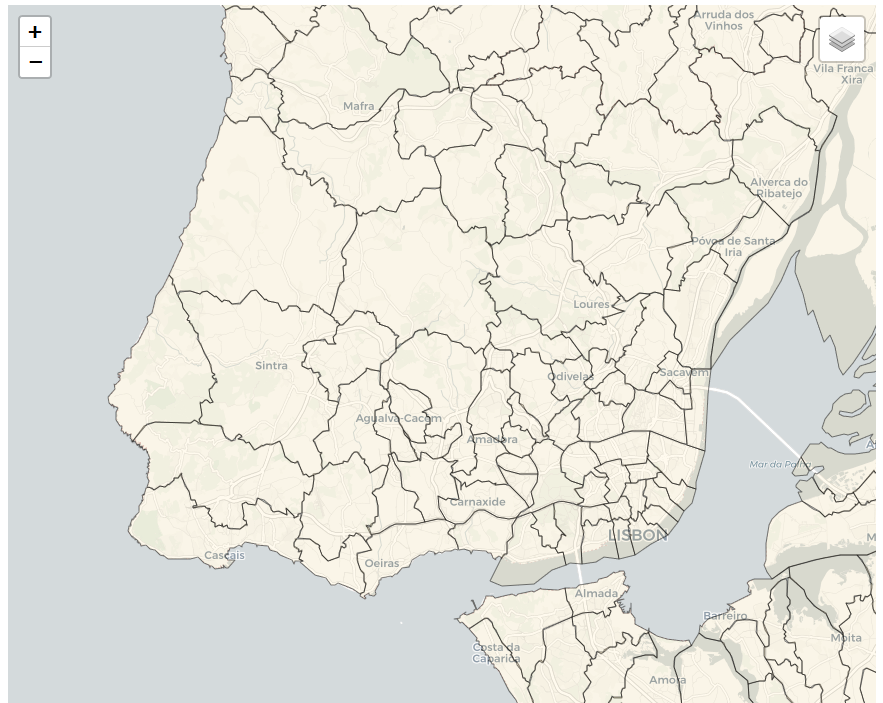

##### **Foursquare**

In [5]:
# @hidden_cell
CLIENT_ID     ='LWPPRHSKBQ3BFLAGZDAKYGZEXEXBAFPOQZQSKZT2IC4J24QW'
CLIENT_SECRET ='ZSWEL3T5T23PGV1WZGU4M5Y1MB2SK5L5MJATBKGXDLWVOSRI'

In [6]:
fs_search_addr  = 'https://api.foursquare.com/v2/venues/search?'
fs_explore_addr = 'https://api.foursquare.com/v2/venues/explore?'
VERSION         = '20200606'
RADIUS          = '15000'
LIMIT           = 1000

In [7]:
def getNearbyVenues(names=None, latitudes=None, longitudes=None, radius=500):
    # in case the lists are empty, return empty list of venues
    if (names==None) | (latitudes==None) | (longitudes==None):
        return []
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            fs_explore_addr,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print('URL: {}'.format(url))
            
        #wait a bit before allowing the request to be performed
        #this tries to avoid lack of responses from foursquare
        time.sleep(2)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print('Sample of the Foursquare data:\n')
        pp.pprint(results[0])
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
try:
    with open( './data/{}_venues.p'.format(study_location), 'rb' ) as v_f:
        study_venues = pk.load(v_f)
        if (not len(coords) > 0):
            raise Exception("No venues data found on file, so please wait while I request the information from the provider...") 
except:
    print('Creating a list of venues in the vicinity of {}...\n'.format(study_location))
    study_venues = getNearbyVenues(names=[study_location],
                                   latitudes=[latitude],
                                   longitudes=[longitude],
                                   radius=RADIUS
                                  )
    pk.dump( study_venues, open( './data/{}_venues.p'.format(study_location), 'wb' ) )
    print('Venues list created.')

study_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,OEIRAS,38.712497,-9.2713,Parque Urbano do Jamor,38.704980,-9.254603,Park
1,OEIRAS,38.712497,-9.2713,Abakua Café,38.710831,-9.289811,Café
2,OEIRAS,38.712497,-9.2713,Hotel Vila Galé Collection Palácio dos Arcos,38.696575,-9.289266,Hotel
3,OEIRAS,38.712497,-9.2713,Casa da Dízima,38.695544,-9.289952,Portuguese Restaurant
4,OEIRAS,38.712497,-9.2713,Centro de Ténis do Jamor,38.708189,-9.252795,Tennis Stadium
...,...,...,...,...,...,...,...
95,OEIRAS,38.712497,-9.2713,Esplanada do Jardim da Estrela,38.714104,-9.159701,Café
96,OEIRAS,38.712497,-9.2713,Eleven,38.730773,-9.155676,Restaurant
97,OEIRAS,38.712497,-9.2713,Taqueria Pistola y Corazon,38.708635,-9.147736,Mexican Restaurant
98,OEIRAS,38.712497,-9.2713,Miradouro de São Pedro de Alcântara,38.715233,-9.144247,Scenic Lookout


##### **Existing Lottery POS locations**

In [9]:
concelhos_lisboa=['ALENQUER', 'AMADORA', 'ARRUDA DOS VINHOS', 'AZAMBUJA', 'CADAVAL', 'CASCAIS', 'LISBOA', 'LOURES', 'LOURINHÃ', 'MAFRA', 'ODIVELAS', 'OEIRAS', 'SINTRA', 'SOBRAL DE MONTE AGRAÇO', 'TORRES VEDRAS', 'VILA FRANCA DE XIRA']

with open('./data/scml-ALENQUER.txt', encoding='utf8') as f:
    html = f.readlines()
    print('Example of the scrapped data:\n')
    pp.pprint(html[0:27])

Example of the scrapped data:

[   '<div class="jstyling-select-t_select7">ALENQUER</div></div>\n',
    '<ul class="salePointSearch3">\n',
    '\n',
    '        <li style="display: list-item;"> \n',
    '          <span class="title">\n',
    '  A PRIMEIRA PAGINA\n',
    '          </span> \n',
    '          <span class="text">\n',
    '            LARGO DO CRESPO,9 <br>\n',
    '              2580 - 017 ABRIGADA <br>\n',
    '              Tel: 263790145<br>\n',
    '              \n',
    '            </span>\n',
    '          </li>\n',
    '\n',
    '        <li style="display: list-item;"> \n',
    '          <span class="title">\n',
    '  PASTELARIA NORBERTO´S\n',
    '          </span> \n',
    '          <span class="text">\n',
    '            PRAC.PEDRO ALVARES CABRAL, LT-9 R/C DT. <br>\n',
    '              2580 - 494 CARREGADO <br>\n',
    '              Tel: 263853155<br>\n',
    '              Fax: 263853155\n',
    '            </span>\n',
    '          </li>\n',
  

### Methodology Overview

The approach of this study will go through the Data Science phases, from the data collection, through data preparation and exploration, to model selection and evaluation. This is a classification goal, so the models will be restricted by that.

## **References**

[1] GeoJSON @ https://geojson-maps.ash.ms/

[2] Foursquare @ https://developer.foursquare.com/docs/places-api/endpoints/

[3] SCML @ https://www.djogos.scml.pt/web/SCMediador/verMediadores